In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

import sys
sys.path.append("./../../")

from modules.dvae.model import DVAE
from modules.transformer_gen.ar_uncond.generator import LatentGenerator
from modules.vit.model import ViT
from modules.common_utils import latent_to_img
from datasets.mnist_loader import MNISTData
from notebooks.utils import show

In [2]:
# This function computes the accuracy on the test dataset
def compute_accuracy(dvae, clf, testloader, device):
    clf.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                latent = dvae.ng_q_encode(images)
                b, emb, h, w = latent.size()
                x = latent.view(b, emb, -1).permute(2, 0, 1)
            outputs = clf(x)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [3]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #DEVICE                      = torch.device("cpu")

    img_channels                = 1
    vocab_size                  = 32
    
    hidden_height               = 7
    hidden_width                = 7

    num_blocks                  = 10
    n_attn_heads                = 8
    hidden_dim                  = 256
    dropout_prob                = 0.1

    dvae_num_x2upsamples        = 2
    dvae_num_resids_downsample  = 3
    dvae_num_resids_bottleneck  = 4
    dvae_hidden_dim             = 256

    mnist_type                  = "classic"
    root_img_path               = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"
    
    dvae_model_path             = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist/"
    dvae_model_name             = "dvae_vocab32_mnist"
    
    gen_model_path              = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/tr/ar_uncond/"
    gen_model_name              = "latent_gen"
    
    NUM_EPOCHS                  = 50
    BATCH_SIZE                  = 128
    LR                          = 0.001
    LR_gamma                    = 0.1
    step_LR_milestones          = [5, 15, 25]


CONFIG = Config()

In [4]:
data_source = MNISTData(
    img_type=CONFIG.mnist_type,
    root_path=CONFIG.root_img_path,
    batch_size=CONFIG.BATCH_SIZE)

train_loader = data_source.get_train_loader()
test_loader = data_source.get_test_loader()

In [5]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim,
    device=CONFIG.DEVICE)

dvae.load_model(
    root_path=CONFIG.dvae_model_path,
    model_name=CONFIG.dvae_model_name)

clf = ViT(
    input_width=CONFIG.hidden_width,
    input_height=CONFIG.hidden_height,
    input_channels=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob,
    n_classes=10,
    device=CONFIG.DEVICE)

dvae.eval()
clf.train()

pass

In [6]:
print("Device in use: {}".format(CONFIG.DEVICE))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=CONFIG.LR)

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for img, label in train_loader:
        
        label = label.to(CONFIG.DEVICE)
        img = img.to(CONFIG.DEVICE)
        
        with torch.no_grad():
            latent = dvae.ng_q_encode(img)
            b, emb, h, w = latent.size()
            x = latent.view(b, emb, -1).permute(2, 0, 1)
        
        optimizer.zero_grad()
        pred = clf(x)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        
    if epoch % 5 == 0:
        print("Epoch: {} Loss: {}".format(epoch, loss.item()))

print('Test Accuracy:', compute_accuracy(dvae, clf, test_loader, CONFIG.DEVICE))

Device in use: cuda
Epoch: 0 Loss: 0.9027866721153259
Epoch: 5 Loss: 0.197040393948555
Epoch: 10 Loss: 0.16844533383846283
Epoch: 15 Loss: 0.07052480429410934
Epoch: 20 Loss: 0.2539893686771393
Epoch: 25 Loss: 0.23797227442264557
Epoch: 30 Loss: 0.10254447907209396
Epoch: 35 Loss: 0.09213659167289734
Epoch: 40 Loss: 0.06402123719453812
Epoch: 45 Loss: 0.02629495970904827
Test Accuracy: 0.975


In [7]:
disc = ViT(
    input_width=CONFIG.hidden_width,
    input_height=CONFIG.hidden_height,
    input_channels=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob,
    n_classes=1,
    sigmoid_output=True,
    device=CONFIG.DEVICE)

G = LatentGenerator(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob,
    device=CONFIG.DEVICE)

G.load_model(
    root_path=CONFIG.gen_model_path,
    model_name=CONFIG.gen_model_name)

disc.train()
G.eval()

pass

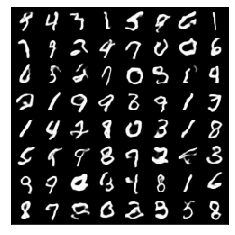

In [8]:
samples = G.sample(n_samples=64)

latent_x = samples.view(CONFIG.hidden_height, CONFIG.hidden_width, 64, CONFIG.vocab_size).permute(2, 3, 0, 1)

with torch.no_grad():
    gen_img = dvae.decode(latent_x)

show(gen_img)

In [9]:
optimizer = optim.Adam(disc.parameters(), lr=CONFIG.LR)

criterion = nn.BCELoss()

for epoch in range(10):
    for img, label in train_loader:
        img = img.to(CONFIG.DEVICE)
        batch, _, _, _ = img.size()

        with torch.no_grad():
            real = dvae.ng_q_encode(img)
            real = real.view(batch, CONFIG.vocab_size, -1).permute(2, 0, 1)
            fake = G.sample(n_samples=batch)
            #fake = latent_to_img(latent_fake, dvae, CONFIG.hidden_height, CONFIG.hidden_width)

        inp = torch.cat([real, fake], dim=1)
        target = torch.cat([
            torch.ones(batch, device=CONFIG.DEVICE), 
            torch.zeros(batch, device=CONFIG.DEVICE)
        ], dim=0)

        optimizer.zero_grad()
        out = disc(inp)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        
    print('Epoch {} Loss {}'.format(epoch, round(loss.item(), 5)))

Epoch 0 Loss 0.65455
Epoch 1 Loss 0.62162
Epoch 2 Loss 0.66748
Epoch 3 Loss 0.65933
Epoch 4 Loss 0.64864
Epoch 5 Loss 0.65961
Epoch 6 Loss 0.67032
Epoch 7 Loss 0.64844
Epoch 8 Loss 0.63282
Epoch 9 Loss 0.64968


=== REAL ===


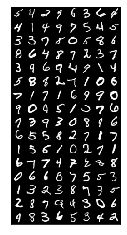

=== FAKE ===


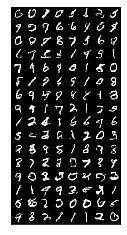

In [10]:
img, label = next(iter(train_loader))
img = img.to(CONFIG.DEVICE)
batch, _, _, _ = img.size()

with torch.no_grad():
    real = dvae.ng_q_encode(img)
    real = real.view(batch, CONFIG.vocab_size, -1).permute(2, 0, 1)
    fake = G.sample(n_samples=batch)

real_lat = latent_to_img(real, dvae, CONFIG.hidden_height, CONFIG.hidden_width)
fake_lat = latent_to_img(fake, dvae, CONFIG.hidden_height, CONFIG.hidden_width)

print('=== REAL ===')
show(real_lat)

print('=== FAKE ===')
show(fake_lat)

inp = torch.cat([real, fake], dim=1)
target = torch.cat([
    torch.ones(batch, device=CONFIG.DEVICE), 
    torch.zeros(batch, device=CONFIG.DEVICE)
], dim=0)

out = disc(inp)

In [13]:
out

tensor([0.6810, 0.2947, 0.7058, 0.4952, 0.4555, 0.5293, 0.4712, 0.5823, 0.3754,
        0.7021, 0.5686, 0.3497, 0.3296, 0.5348, 0.4343, 0.6414, 0.3082, 0.4709,
        0.3276, 0.4260, 0.5893, 0.4834, 0.4254, 0.4859, 0.6473, 0.6795, 0.5943,
        0.5870, 0.5586, 0.5144, 0.4849, 0.5134, 0.5773, 0.6568, 0.4919, 0.4057,
        0.5241, 0.4042, 0.4103, 0.5253, 0.5461, 0.3842, 0.5727, 0.5276, 0.6932,
        0.5715, 0.6697, 0.5223, 0.5690, 0.5457, 0.5602, 0.4521, 0.7074, 0.5999,
        0.5748, 0.5581, 0.5391, 0.3682, 0.6593, 0.4972, 0.3673, 0.6111, 0.3469,
        0.6859, 0.4039, 0.4396, 0.8377, 0.3068, 0.4580, 0.5578, 0.6243, 0.4789,
        0.4886, 0.5672, 0.6894, 0.3614, 0.5745, 0.4966, 0.2065, 0.5728, 0.5360,
        0.5026, 0.6537, 0.5414, 0.4756, 0.5996, 0.4457, 0.5413, 0.5856, 0.6483,
        0.2552, 0.4190, 0.4564, 0.4351, 0.7682, 0.5159, 0.4356, 0.5202, 0.4206,
        0.6350, 0.6994, 0.5423, 0.4761, 0.6092, 0.5417, 0.6811, 0.5001, 0.5028,
        0.4566, 0.6390, 0.3963, 0.4378, 

In [12]:
out.round()

tensor([1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 